<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Computer%20Vision/Rock_life_detection_Classification_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from IPython.display import clear_output
!pip install imutils
clear_output

<function IPython.core.display.clear_output(wait=False)>

In [6]:


import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
#from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")


All modules have been imported


In [7]:


import os
import shutil
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras



In [8]:
rock_dir = "/content/DatasetRockLife"

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

batch_size = 16

In [9]:


from tensorflow.keras.applications import ResNet50
# Load pre-trained ResNet-50 model without the top (fully connected) layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained ResNet-50 layers
for layer in resnet_base.layers:
    layer.trainable = True

# Create the rest of your model
model = keras.Sequential([
    keras.layers.Rescaling(scale=1/255, input_shape=(224, 224, 3)),

    resnet_base,

    keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(38, activation='sigmoid')
])

model.summary()



94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                         

In [15]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(


    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])



In [11]:


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can use other metrics like 'val_accuracy'
    patience=5,          # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore the best model weights when early stopping
)



Load the dataset¶

In [16]:


train_ds, test_ds = keras.utils.image_dataset_from_directory(
    rock_dir ,
    image_size=(224,224),
    batch_size=32,
    seed = 123,
    validation_split=.2,
    subset='both'
)



Found 1792 files belonging to 9 classes.
Using 1434 files for training.
Using 358 files for validation.


Train the model

In [17]:
history = model.fit(train_ds, epochs=33, validation_data=test_ds)  #, callbacks=[early_stopping])

Epoch 1/33
45/45 [==============================] - 53s 425ms/step - loss: 2.3138 - accuracy: 0.3271 - val_loss: 5774.5361 - val_accuracy: 0.1006
Epoch 2/33
45/45 [==============================] - 17s 348ms/step - loss: 2.1430 - accuracy: 0.3515 - val_loss: 5.4647 - val_accuracy: 0.1034
Epoch 3/33
45/45 [==============================] - 18s 381ms/step - loss: 2.0734 - accuracy: 0.3368 - val_loss: 7.4646 - val_accuracy: 0.1034
Epoch 4/33
45/45 [==============================] - 17s 349ms/step - loss: 1.9235 - accuracy: 0.3682 - val_loss: 12.4532 - val_accuracy: 0.1034
Epoch 5/33
45/45 [==============================] - 16s 348ms/step - loss: 1.8318 - accuracy: 0.3863 - val_loss: 11.0232 - val_accuracy: 0.1034
Epoch 6/33
45/45 [==============================] - 19s 386ms/step - loss: 1.8925 - accuracy: 0.3780 - val_loss: 8.6109 - val_accuracy: 0.1034
Epoch 7/33
45/45 [==============================] - 17s 350ms/step - loss: 1.8550 - accuracy: 0.3801 - val_loss: 15.4630 - val_accuracy: 

Evaluation

In [18]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = [label for _, label in test_ds.unbatch()]
print(classification_report(true_labels, predicted_labels))

12/12 [==============================] - 3s 111ms/step
              precision    recall  f1-score   support

           0       0.63      0.32      0.43        37
           1       0.38      0.56      0.45        34
           2       0.74      0.30      0.43        56
           3       0.56      0.41      0.47        37
           4       0.32      0.49      0.38        39
           5       0.58      0.55      0.57        38
           6       0.19      0.51      0.28        41
           7       0.80      0.20      0.32        40
           8       0.91      0.58      0.71        36

    accuracy                           0.43       358
   macro avg       0.57      0.44      0.45       358
weighted avg       0.57      0.43      0.44       358



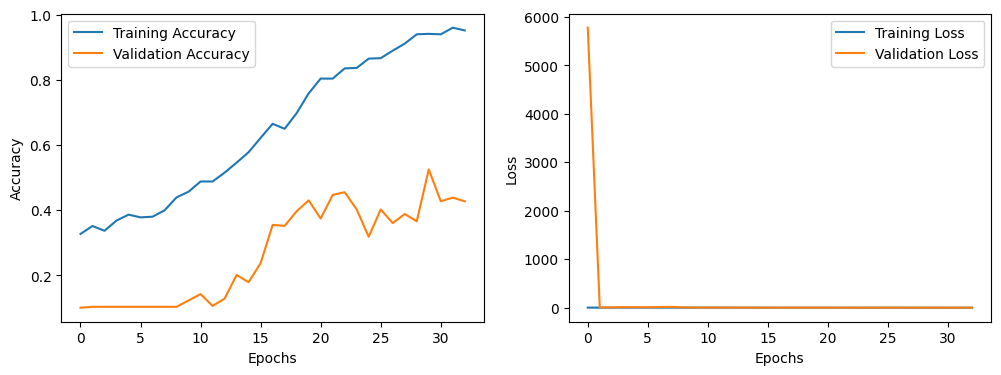

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()